In [1]:
import matplotlib.pyplot as plt
import numpy as np

import time

import sys
import os

from datetime import datetime
import subprocess



from os.path import exists


In [2]:
print("\n\n")
print("  numpy version:  %s" % str(np.version.version) )

print("\n\n")




  numpy version:  1.26.4





## Set model and resolution parameters

In [3]:
ndim = 1


of_niter = 5


smearing_val = 0.0000
#smearing_val = 0.1184
#smearing_val = 0.2368
#smearing_val = 0.3553
#smearing_val = 0.5132
#smearing_val = 0.7500




input_dir = 'input-samples/input-samples-smearing-%6.4f-v1b' % smearing_val


output_dir = 'output-run-kde-study-1d-read-input-v0a-smearing-%6.4f' % smearing_val



#-- parameters for simple pdf

hist_low = -10.
hist_high = 10.

hist_nbins = 1000


hist_binwidth = (hist_high - hist_low) / hist_nbins

window_dx = 0.10

window_nbins = int( window_dx / hist_binwidth )

print(' window_nbins : %d' % window_nbins)

hist_pars = {}
hist_pars['low']  = hist_low
hist_pars['high'] = hist_high
hist_pars['nbins'] = hist_nbins
hist_pars['binwidth'] = hist_binwidth
hist_pars['window_dx'] = window_dx
hist_pars['window_nbins'] = window_nbins



 window_nbins : 5


In [4]:
hist_pars

{'low': -10.0,
 'high': 10.0,
 'nbins': 1000,
 'binwidth': 0.02,
 'window_dx': 0.1,
 'window_nbins': 5}

In [5]:
try:
    os.mkdir( output_dir )
except:
    print('\n\n Output directory already exists:  %s' % output_dir)
    #print('\n\n HALTING EXECUTION\n\n')
    #sys.exit()

In [6]:
config_file = open('%s/config.txt' % output_dir, 'w' )

config_file.write('  input_dir  %s\n' % input_dir )
config_file.write(' of_niter %d\n' % of_niter )
config_file.write( 'hist pars %s\n' % str(hist_pars) )
config_file.close()

print( subprocess.getoutput('cat %s/config.txt' % output_dir ))



  input_dir  input-samples/input-samples-smearing-0.0000-v1b
 of_niter 5
hist pars {'low': -10.0, 'high': 10.0, 'nbins': 1000, 'binwidth': 0.02, 'window_dx': 0.1, 'window_nbins': 5}


## Count the number of samples in the input directory and read in the first one

In [7]:
n_samples = 0

for fi in range(5000) :
    
    fname = '%s/sample-%04d.npz' % (input_dir, fi)
    
    if exists(fname) :
        n_samples = n_samples + 1
        
print("\n\n Found %d samples.\n\n" % n_samples )



 Found 500 samples.




In [8]:
def read_sample( input_dir, sample_index ) :
    
    with np.load( '%s/sample-%04d.npz' % (input_dir, sample_index) ) as f :
        #read_true_pts = np.load(f)
        read_true_det_pts = f['data']
        read_train_pts = f['gen']
        read_train_det_pts = f['sim']

    ngen_true = len(read_true_det_pts)
    ngen_train = len(read_train_pts)

    this_ngen_true = ngen_true

    #-- package these in the same format as what I was using.

    #true_pts = np.zeros( shape=(ngen_true,1) )
    #true_pts[:,0] = read_true_pts

    true_det_pts = np.zeros( shape=(ngen_true,1) )
    true_det_pts[:,0] = read_true_det_pts

    train_pts = np.zeros( shape=(ngen_train,1) )
    train_pts[:,0] = read_train_pts

    train_det_pts = np.zeros( shape=(ngen_train,1) )
    train_det_pts[:,0] = read_train_det_pts
    
    return_dict = {}
    
    #return_dict['true_pts'] = true_pts
    return_dict['true_det_pts'] = true_det_pts
    return_dict['train_pts'] = train_pts
    return_dict['train_det_pts'] = train_det_pts
    return_dict['ngen_true'] = ngen_true
    return_dict['ngen_train'] = ngen_train
    
    return return_dict
    
    

In [9]:

rd = read_sample( input_dir, 0 )

ngen_true = rd['ngen_true']
ngen_train = rd['ngen_train']

#true_pts = rd['true_pts']
true_det_pts = rd['true_det_pts']
train_pts = rd['train_pts']
train_det_pts = rd['train_det_pts']


print('  true_pts:   ngen_true  = %8d,  shape = %s' % (ngen_true, str(true_det_pts.shape)) )
print('  train_pts:  ngen_train = %8d,  shape = %s' % (ngen_train, str(train_pts.shape)) )


  true_pts:   ngen_true  =    10039,  shape = (10039, 1)
  train_pts:  ngen_train =   100000,  shape = (100000, 1)


## Function that estimates the pdf from a histogram (multi-bin sum)

In [10]:

#-- computes pdf2/pdf1 at location of points1
#
#    for OmniFold step 1, points2 is the data, points1 is the MC
#

def pdf_ratio_from_hist( points1, points2, weights1, weights2, hist_pars, verbose=0 ) :
    
    ndim = points1.shape[1]
    
    if ndim > 1 :
        print('\n\n *** Only 1D supported for now.\n\n')
        sys.exit()
        
    hist_low = hist_pars['low']
    hist_high = hist_pars['high']
    hist_nbins = hist_pars['nbins']
    hist_binwidth = hist_pars['binwidth']
    
    
    nph1 = np.histogram( points1[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights1 )
    nph2 = np.histogram( points2[:,0], hist_nbins, range=[hist_low, hist_high], weights=weights2 )
    
    hist_pdf1 = np.zeros(hist_nbins)
    hist_pdf2 = np.zeros(hist_nbins)

    for bi in range( hist_nbins ) :
        bilow = bi - window_nbins
        bihigh = bi + window_nbins
        if bilow < 0 : bilow = 0
        if bihigh >= hist_nbins : bihigh = hist_nbins-1

        hist_pdf1[bi] = np.sum( nph1[0][bilow: bihigh] )
        hist_pdf2[bi] = np.sum( nph2[0][bilow: bihigh] )
    
    hist_pdf1_norm = hist_pdf1 / np.sum(hist_pdf1)
    hist_pdf2_norm = hist_pdf2 / np.sum(hist_pdf2)
    
    hist_bin_indices1 = np.array(   ( (points1[:,0] - hist_low) / hist_binwidth ),   dtype=int )
    
    points1_pdf1_val = hist_pdf1_norm[ hist_bin_indices1 ]
    points1_pdf2_val = hist_pdf2_norm[ hist_bin_indices1 ]
    
    points1_pdf1_val = np.clip( points1_pdf1_val, 1.e-10, 1.e10)
    points1_pdf2_val = np.clip( points1_pdf2_val, 1.e-10, 1.e10)
    
    pdf_ratio = points1_pdf2_val / points1_pdf1_val
    
    return pdf_ratio
    

## Define OmniFold implementation with Simple pdf

In [11]:
def hist_pdf_omnifold1a( theta0, theta_unknown_S, iterations, verbose=0 ) :
    
    weights = np.empty(shape=(iterations, 2, len(theta0)))
    # shape = (iteration, step, event)
    push_weights_for_output = np.empty(shape=(iterations, len(theta0)))

    theta0_G = theta0[:,0]
    theta0_S = theta0[:,1]

    ngen_train = len(theta0)
    of_ngen_true  = len(theta_unknown_S)
    ndim = theta0_G.shape[1]

    labels0 = np.zeros(len(theta0))
    labels_unknown = np.ones(len(theta_unknown_S))
    labels_unknown_step2 = np.ones(len(theta0_G))


    neval_train = ngen_train
    neval_true  = of_ngen_true


    if verbose :
        print("\n\n")
        print("  ======== simple_pdf2b\n\n")
        print("  shape of theta0_S : %s" % str(np.shape(theta0_S)) )
        print("  shape of theta0_G : %s" % str(np.shape(theta0_G)) )
        print("  shape of theta_unknown_S : %s" % str(np.shape(theta_unknown_S)) )
        print("\n  iterations = %d\n" % iterations )
        print("  ndim : %d" % ndim )
        print("  neval_train : %d" % neval_train )
        print("  neval_true  : %d" % neval_true )
        print("\n\n")

    # initial iterative weights are ones
    weights_pull = np.ones(len(theta0_S))
    weights_push = np.ones(len(theta0_S))


    sample_norm_sf = ( (1.*neval_train)/(1.*neval_true) ) *  ( (1.*of_ngen_true)/(1.*ngen_train) )
    
    
    if verbose :
        print('\n\n Calculating model pars for data or true (theta_unknown_S)')
        
    

    
    
    
    
    
    
    return_dict = {}
    
    for i in range(iterations):
    
        if (verbose>0):
            print("\nITERATION: {}\n".format(i + 1))
            
        if (verbose>0):
            print("   -- ITERATION %d  STEP 1\n" % (i+1) )
            
        print(" weights_push at the beginning")
        print( weights_push )

        


        pdf_ratio_step1 = pdf_ratio_from_hist( theta0_S, 
                                              theta_unknown_S, 
                                              weights_push, 
                                              np.ones( of_ngen_true ),
                                              hist_pars
                                             )
        if verbose>0 :
            print(' pdf_ratio_step1:  shape %s ' % str(pdf_ratio_step1.shape))
            print(pdf_ratio_step1)
        
        
        step1_output_weights = sample_norm_sf * pdf_ratio_step1

        weights_pull = weights_push * step1_output_weights
        
        if verbose>0 :
            print("  iter %d, step1_output_weights:  shape %s" % (i+1, str(step1_output_weights.shape)))
            print(step1_output_weights)


        weights[i, :1, :] = step1_output_weights


            
            

        if (verbose>0):
            print("\n   -- ITERATION %d  STEP 2\n" % (i+1) )
            
       

        
        pdf_ratio_step2 = pdf_ratio_from_hist( theta0_G, 
                                              theta0_G, 
                                              weights_push, 
                                              weights_pull,
                                              hist_pars
                                             )
        
        
        step2_output_weights = pdf_ratio_step2
        
        weights_push = weights_push * step2_output_weights
        
        push_weights_for_output[i] = weights_push
        
        weights[i, 1:2, :] = step2_output_weights
        
        if verbose>0 :
           print("  iter %d, step2_output_weights:" % (i+1))
           print(step2_output_weights)
        
    return_dict["weights"] = weights

    return_dict["push_weights"] = push_weights_for_output

    return_dict["final_push_weights"] = weights_push

    return return_dict
            
            

In [12]:
train_both = np.stack([train_pts, train_det_pts], axis=1)

In [13]:
rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 1 )




  ======== simple_pdf2b


  shape of theta0_S : (100000, 1)
  shape of theta0_G : (100000, 1)
  shape of theta_unknown_S : (10039, 1)

  iterations = 5

  ndim : 1
  neval_train : 100000
  neval_true  : 10039





 Calculating model pars for data or true (theta_unknown_S)

ITERATION: 1

   -- ITERATION 1  STEP 1

 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 pdf_ratio_step1:  shape (100000,) 
[0.94486151 1.24572137 0.59241193 ... 0.72866279 0.88527037 1.17469396]
  iter 1, step1_output_weights:  shape (100000,)
[0.94486151 1.24572137 0.59241193 ... 0.72866279 0.88527037 1.17469396]

   -- ITERATION 1  STEP 2

  iter 1, step2_output_weights:
[0.9540787  1.24328891 0.59727325 ... 0.74037765 0.90142884 1.22017726]

ITERATION: 2

   -- ITERATION 2  STEP 1

 weights_push at the beginning
[0.9540787  1.24328891 0.59727325 ... 0.74037765 0.90142884 1.22017726]
 pdf_ratio_step1:  shape (100000,) 
[0.98842353 1.00365992 0.97304053 ... 0.97227531 0.98244451 0.96365973]
  iter 2, ste

In [14]:
of_weights = rd["weights"]

mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))

push_weights = rd["push_weights"]
push_weights_scaled = np.copy( push_weights )
push_weights_scaled = mc_weight_sf * push_weights

final_push_weights = rd["final_push_weights"]
final_push_weights_scaled = np.copy(final_push_weights)
final_push_weights_scaled = mc_weight_sf * final_push_weights

with open( '%s/omnifold-output-weights.npy' % output_dir, 'wb') as f :
    np.save(f, final_push_weights_scaled)


<function matplotlib.pyplot.show(close=None, block=None)>

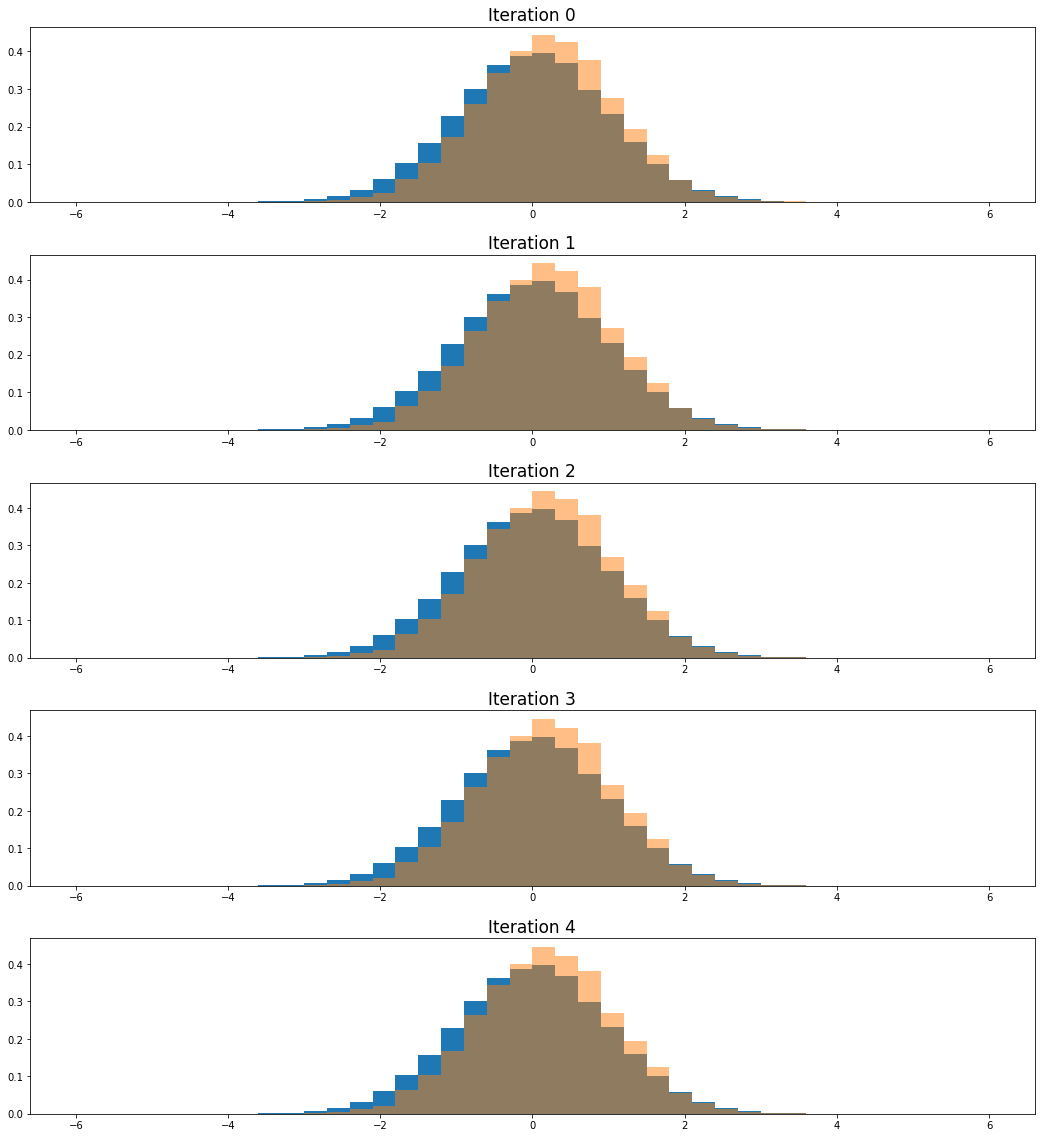

In [15]:


fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            ###hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

            #hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
                
            hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )            
            ###hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        
            #hist_data_truth[ofi,di],_,_ =         thisax.hist( true_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    

 
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
        
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [16]:
hist_data_diff = hist_data_mc_ofweighted - hist_data_truth
hist_data_diff2 = hist_data_diff * hist_data_diff

hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        hist_data_sum_diff2[ofi,di] = np.sum( hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

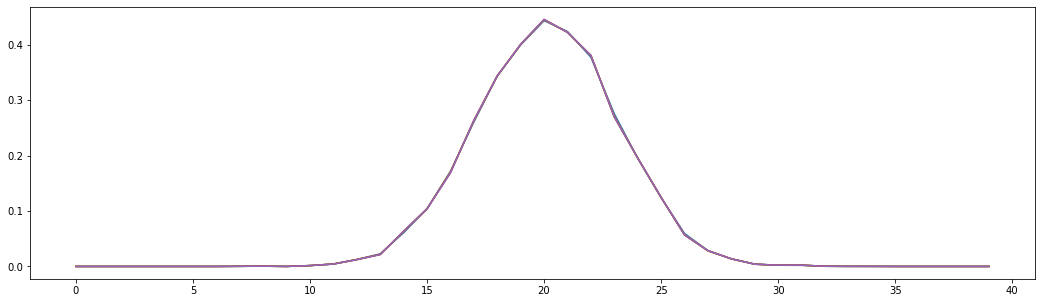

In [17]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

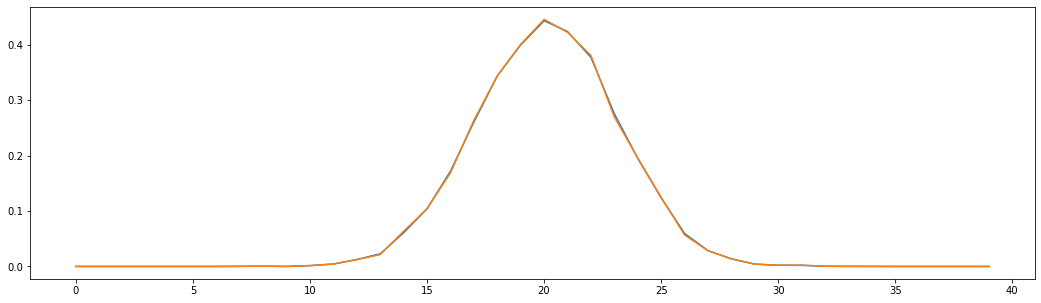

In [18]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(hist_data_diff[ofi,di])
    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

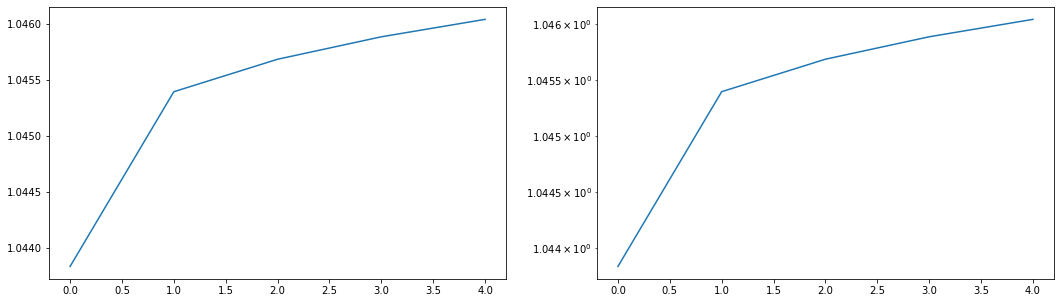

In [19]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( hist_data_sum_diff2)
ax[1].plot( hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

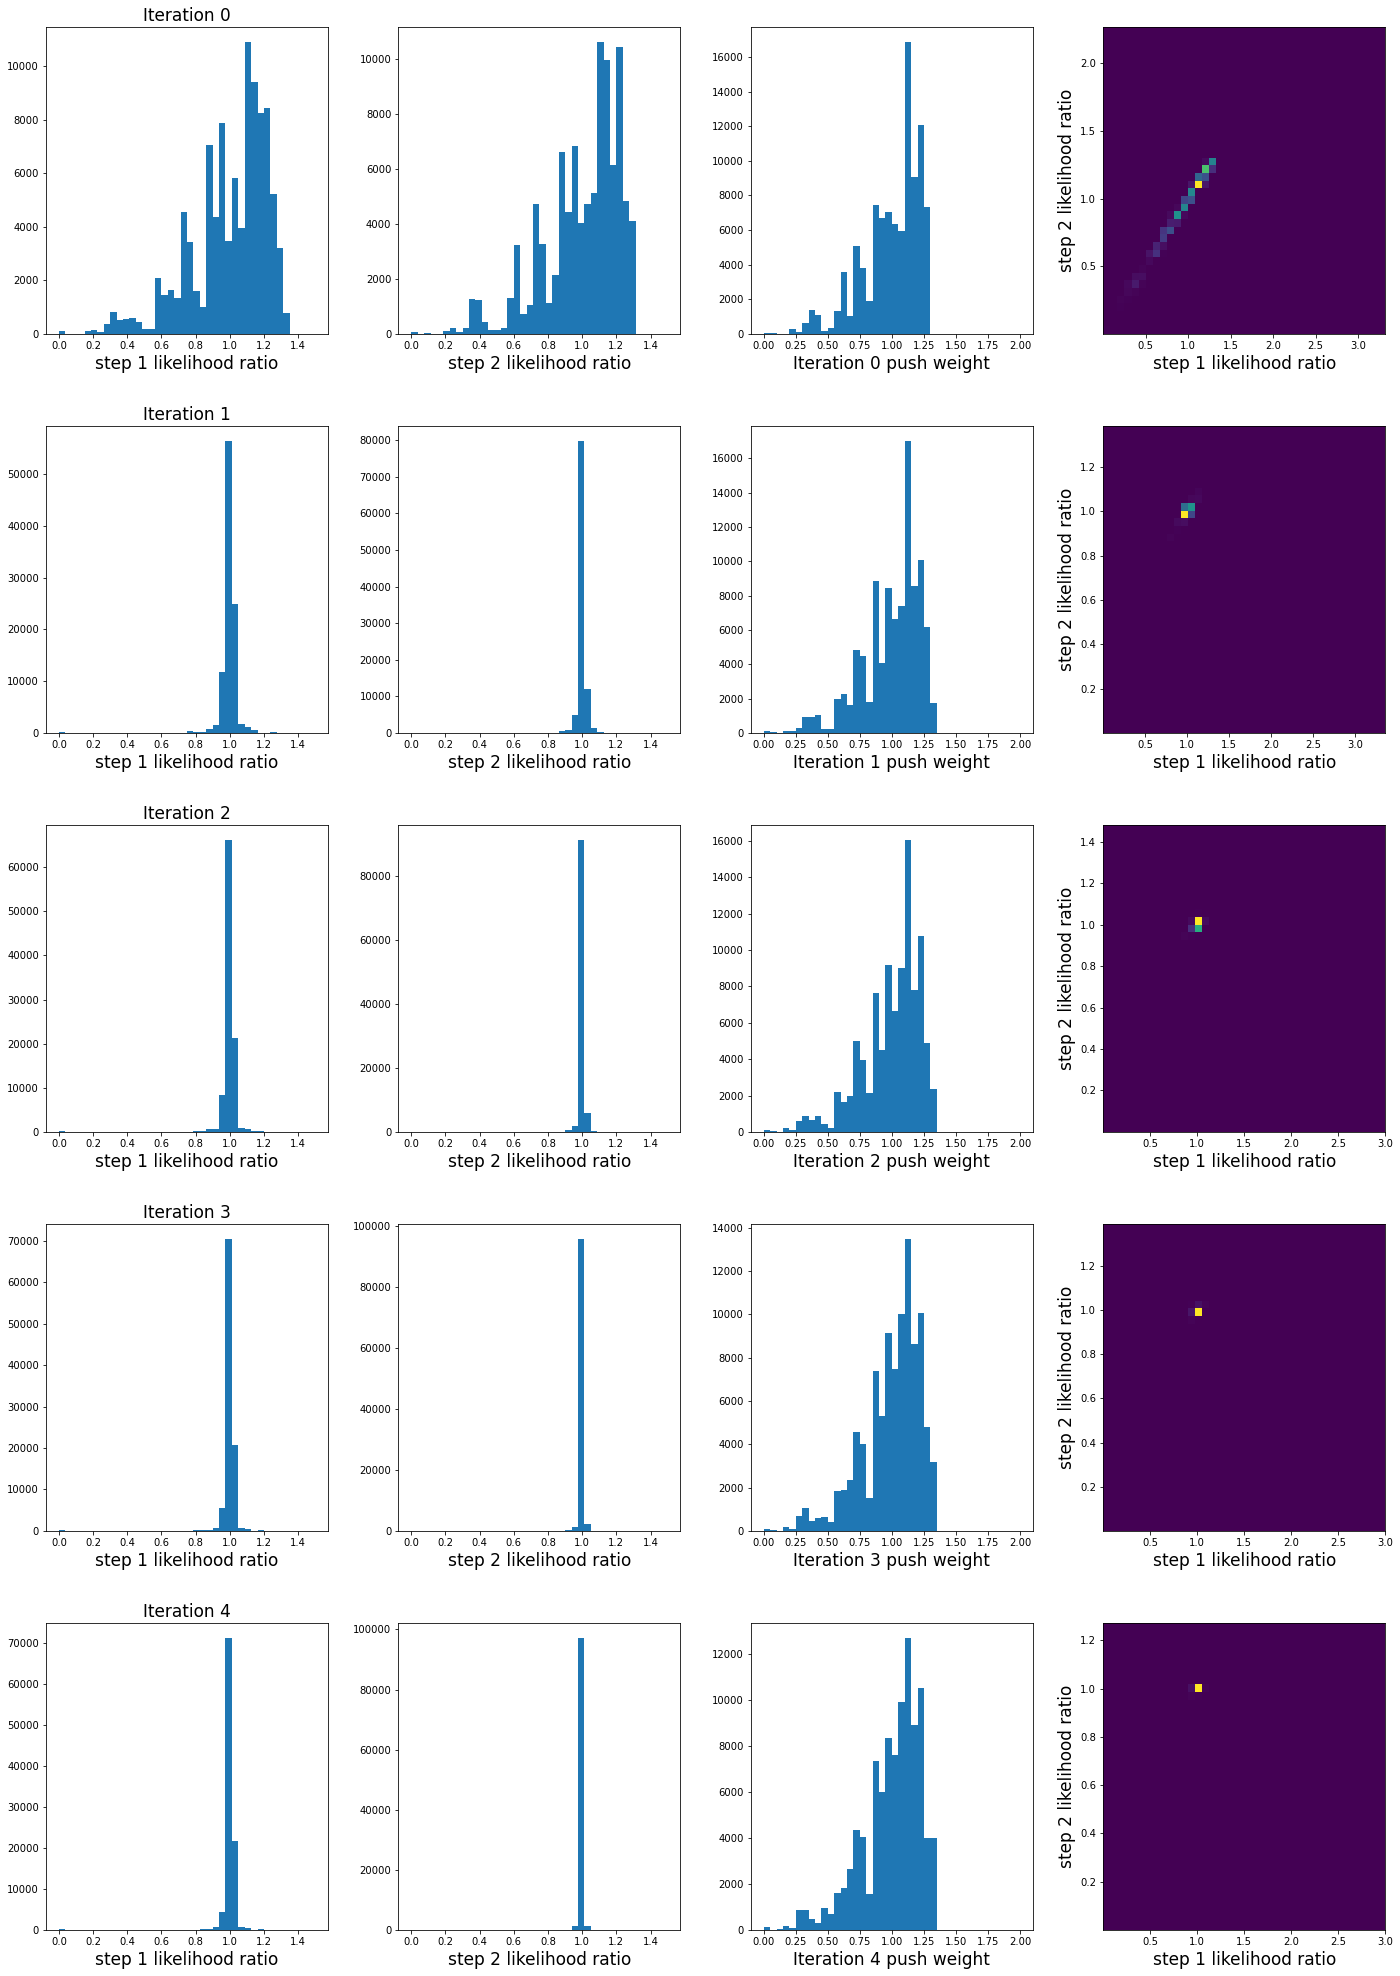

In [20]:
fig,ax = plt.subplots( of_niter, 4, figsize=(24,7*of_niter))

hmin=-6
hmax=6
hbins=40

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

for ofi in range(0,of_niter) :

    ax[ofi][0].hist( of_weights[ofi,0,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][1].hist( of_weights[ofi,1,:], bins=hbins, range=[0.,1.5] )
    
    ax[ofi][2].hist( push_weights[ofi,:], bins=hbins, range=[0.,2.0] )
    #ax[ofi][2].hist( calc_weight, bins=hbins, range=[0.,2.0], alpha=0.5 )
    
    
    ax[ofi][3].hist2d( of_weights[ofi,0,:], of_weights[ofi,1,:], bins=[hbins,hbins] )
    
    ax[ofi][0].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][1].set_xlabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][3].set_xlabel( 'step 1 likelihood ratio', fontsize=lfontsize )
    ax[ofi][3].set_ylabel( 'step 2 likelihood ratio', fontsize=lfontsize )
    
    ax[ofi][2].set_xlabel( 'Iteration %d push weight' % ofi, fontsize=lfontsize )
    
    ax[ofi][0].set_title('Iteration %d' % ofi, fontsize=lfontsize )
    
    
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

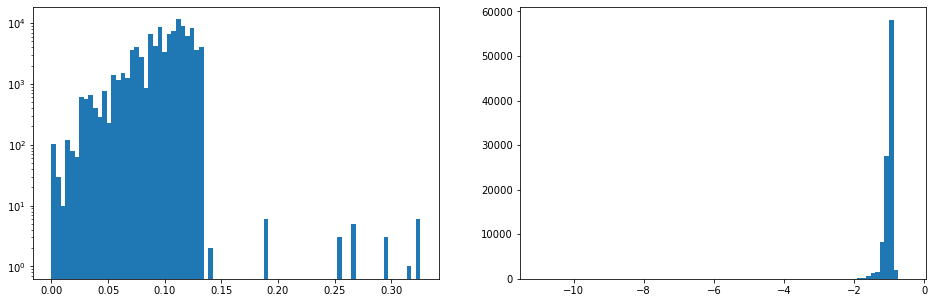

In [21]:
fig,ax = plt.subplots( 1, 2, figsize=(8*2,5))

hbins=80

final_push_weights_scaled = np.clip( final_push_weights_scaled, 1e-11, 1e11)

ax[0].hist( final_push_weights_scaled, bins=hbins)
ax[0].set_yscale('log')

ax[1].hist( np.log10(final_push_weights_scaled), bins=hbins)

plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

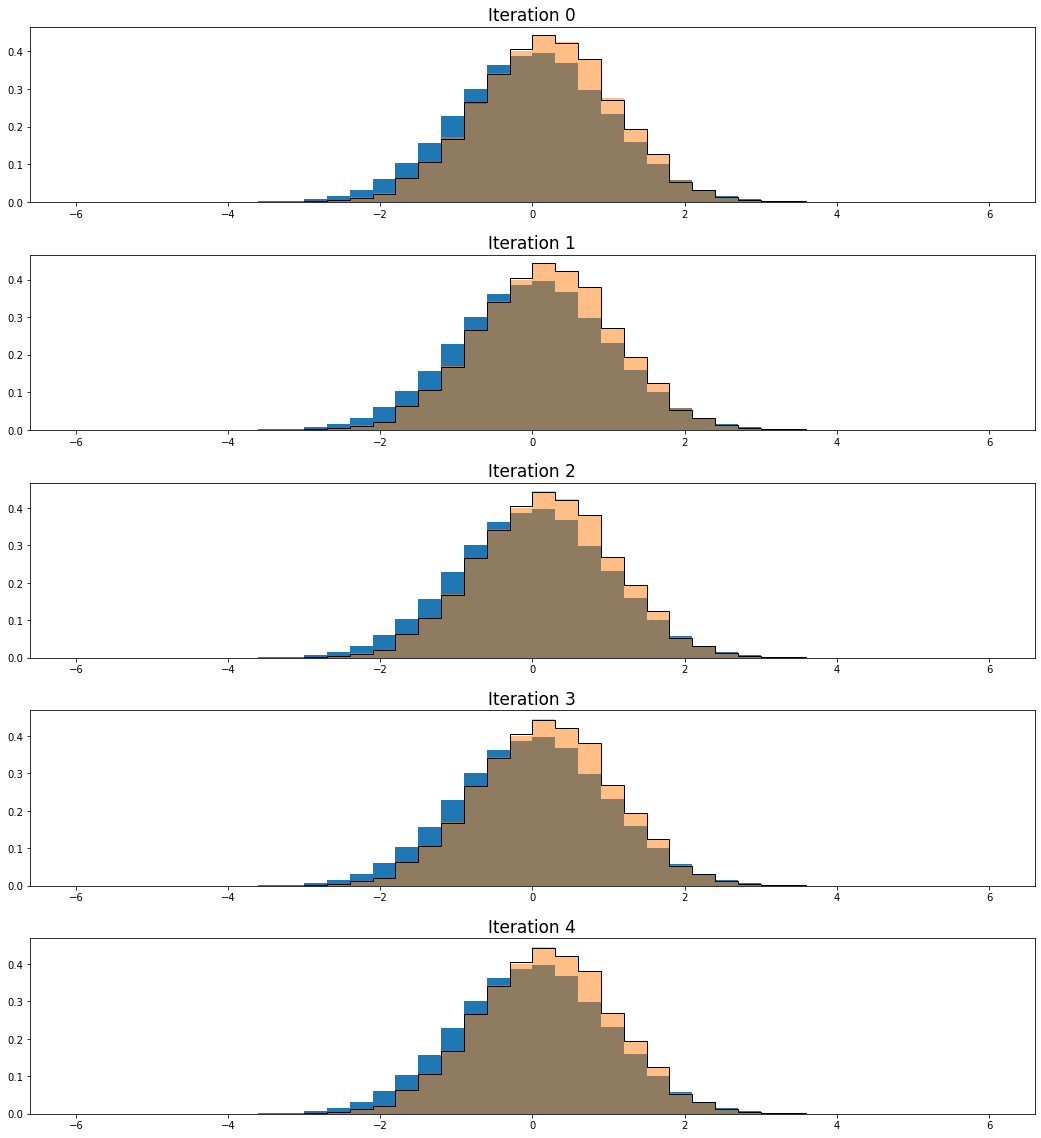

In [22]:

fig,ax = plt.subplots( of_niter, ndim, figsize=(18,4*of_niter))

hmin=-6
hmax=6
hbins=40

det_hist_data_mc_ofweighted = np.zeros( shape=(of_niter,ndim,hbins))
det_hist_data_truth         = np.zeros( shape=(of_niter,ndim,hbins))

lfontsize = 17

plt.subplots_adjust( hspace=0.30)
plt.subplots_adjust( wspace=0.25)

do_renorm = True


for ofi in range(0,of_niter) :

    if do_renorm :
        
        for di in range(ndim) :
            
            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
            
            thisax.hist( train_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='train particle' )
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights[ofi], bins=hbins, density=True, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts[:,di], bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

            #det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, density=True, range=[hmin,hmax], label='true particle', histtype='step', color='black' )

            
    else :
        
        for di in range(ndim) :

            if ndim > 1 :
                thisax = ax[ofi][di]
            else :
                thisax = ax[ofi]
        
            det_hist_data_mc_ofweighted[ofi,di],_,_ = thisax.hist( train_det_pts[:,di], weights=push_weights_scaled[ofi], bins=hbins, range=[hmin,hmax], label='OF weighted particle', alpha=0.5 )
            det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts[:,di], bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
            
            #det_hist_data_truth[ofi,di],_,_ =         thisax.hist( true_det_pts10x[:,di], weights=true_pts10x_weights, bins=hbins, range=[hmin,hmax], label='true particle', histtype='step', color='black' )
        

    

    
    if ndim > 1 :
        thisax = ax[ofi][0]
    else :
        thisax = ax[ofi]
    
    thisax.set_title('Iteration %d' % ofi, fontsize=lfontsize )



plt.show

In [23]:
det_hist_data_diff = det_hist_data_mc_ofweighted - det_hist_data_truth
det_hist_data_diff2 = det_hist_data_diff * det_hist_data_diff

det_hist_data_sum_diff2 = np.zeros( shape=(of_niter,ndim))

for ofi in range( of_niter ) :
    for di in range( ndim ) :
        det_hist_data_sum_diff2[ofi,di] = np.sum( det_hist_data_diff2[ofi,di])


<function matplotlib.pyplot.show(close=None, block=None)>

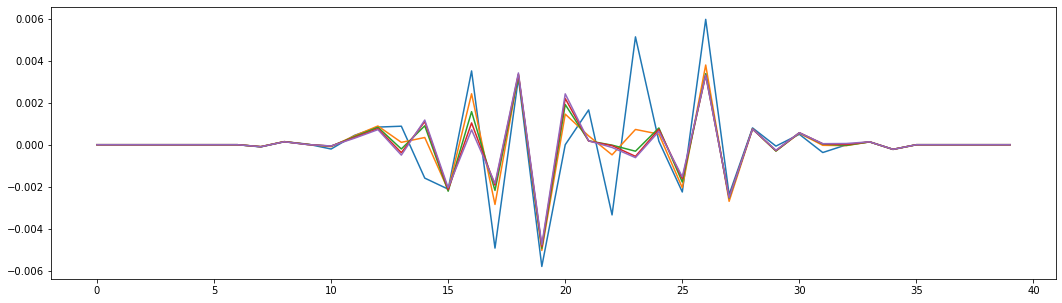

In [24]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

for ofi in range(of_niter) :
    for di in range( ndim ) :
        if ndim > 1 :
            thisax = ax[di]
        else :
            thisax = ax
        thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show   

<function matplotlib.pyplot.show(close=None, block=None)>

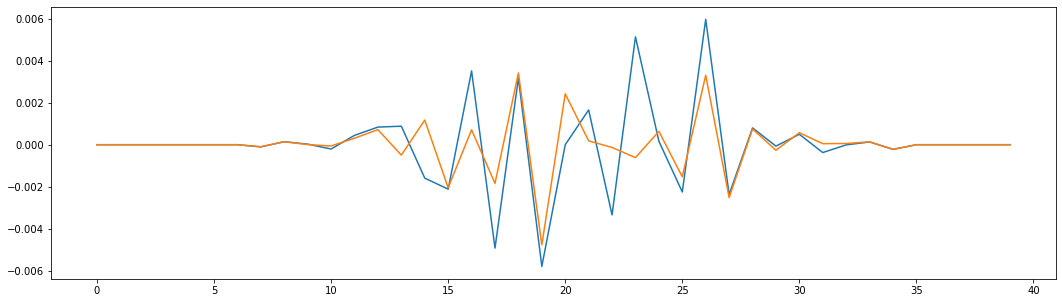

In [25]:
fig,ax = plt.subplots( 1, ndim, figsize=(18,5))

ofi = 0
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

ofi = of_niter-1
for di in range( ndim ) :
    if ndim > 1 :
        thisax = ax[di]
    else :
        thisax = ax
    thisax.plot(det_hist_data_diff[ofi,di])

    
plt.show 

<function matplotlib.pyplot.show(close=None, block=None)>

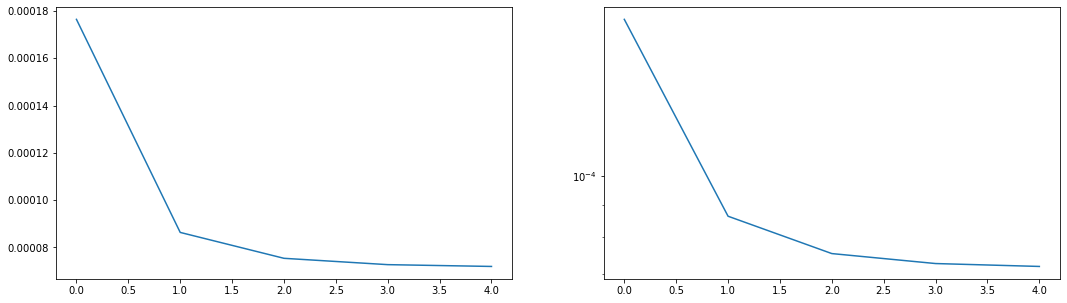

In [26]:
fig,ax = plt.subplots( 1, 2, figsize=(18,5))
ax[0].plot( det_hist_data_sum_diff2)
ax[1].plot( det_hist_data_sum_diff2)
ax[1].set_yscale('log')
plt.show

In [27]:
step1_mean = np.zeros( of_niter )
step1_rms = np.zeros( of_niter )

step2_mean = np.zeros( of_niter )
step2_rms = np.zeros( of_niter )

iter_val = np.zeros( of_niter )

for ofi in range( of_niter ) :
    
    iter_val[ofi] = ofi
    
    step1_mean[ofi] = np.mean( of_weights[ofi,0,:] )
    step1_rms[ofi] = np.sqrt( np.var( of_weights[ofi,0,:]))
    
    step2_mean[ofi] = np.mean( of_weights[ofi,1,:] )
    step2_rms[ofi] = np.sqrt( np.var( of_weights[ofi,1,:]))
    
    print("  iter %2d : step 1 mean  %.3f  rms %.3f      step 2 mean  %.3f  rms %.3f" % 
          (ofi, step1_mean[ofi], step1_rms[ofi], step2_mean[ofi], step2_rms[ofi]) )

  iter  0 : step 1 mean  0.999  rms 0.227      step 2 mean  0.998  rms 0.225
  iter  1 : step 1 mean  0.999  rms 0.053      step 2 mean  0.999  rms 0.032
  iter  2 : step 1 mean  0.998  rms 0.047      step 2 mean  0.999  rms 0.027
  iter  3 : step 1 mean  0.999  rms 0.045      step 2 mean  0.999  rms 0.025
  iter  4 : step 1 mean  0.999  rms 0.044      step 2 mean  0.999  rms 0.024


<function matplotlib.pyplot.show(close=None, block=None)>

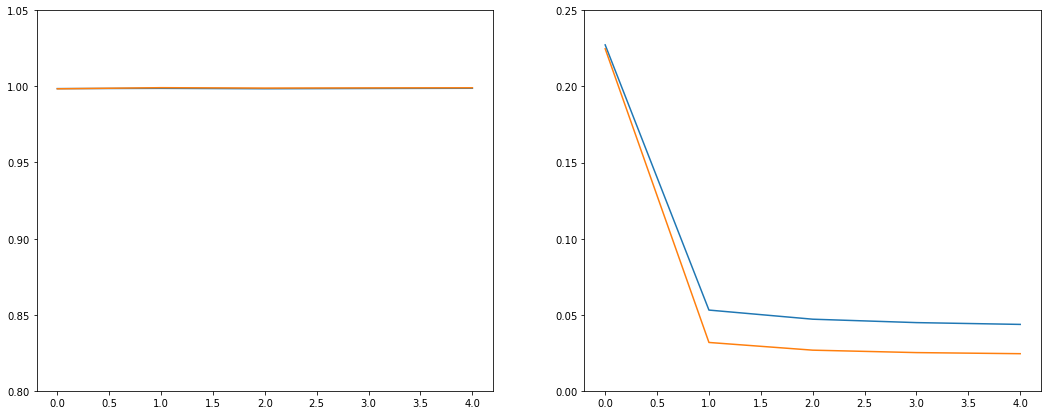

In [28]:
fig,ax = plt.subplots( 1, 2, figsize=(18,7))

ax[0].plot( iter_val, step1_mean )
ax[0].plot( iter_val, step2_mean )
ax[0].set_ylim( 0.80, 1.05)

ax[1].plot( iter_val, step1_rms )
ax[1].plot( iter_val, step2_rms )
ax[1].set_ylim( 0, 1.1*np.max(step1_rms))


plt.show

In [29]:

verbose = False



import gc

In [30]:
%%time

rng = np.random.default_rng()

for bi in range(0,n_samples) :

    print('\n\n\n ==== processing sample %6d' % bi )
        
    rd = read_sample( input_dir, bi )

    ngen_true = rd['ngen_true']
    ngen_train = rd['ngen_train']

    #true_pts = rd['true_pts']
    true_det_pts = rd['true_det_pts']
    train_pts = rd['train_pts']
    train_det_pts = rd['train_det_pts']
    
    train_both = np.stack([train_pts, train_det_pts], axis=1)
        
    
    rd = hist_pdf_omnifold1a( train_both, true_det_pts, of_niter, 0 )
    
    
    
    mc_weight_sf = (1.*len(true_det_pts))/(1.*len(train_both))



    boot_final_push_weights = rd["final_push_weights"]
    boot_final_push_weights_scaled = boot_final_push_weights
    boot_final_push_weights_scaled = mc_weight_sf * boot_final_push_weights
    
    print("\n\n bootstrap %d final push weights scaled:" % bi)
    print( boot_final_push_weights_scaled )

     
    with open( '%s/bootstrap-weights-%03d.npy' % ( output_dir, bi ), 'wb' ) as f :
        np.save( f, boot_final_push_weights_scaled )
        
    del boot_final_push_weights_scaled
    del rd
    gc.collect()
    
    




 ==== processing sample      0
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9540787  1.24328891 0.59727325 ... 0.74037765 0.90142884 1.22017726]
 weights_push at the beginning
[0.95323079 1.25120639 0.58201568 ... 0.72411172 0.89976284 1.21996334]
 weights_push at the beginning
[0.95139826 1.24926531 0.56730304 ... 0.71536842 0.89698322 1.2181806 ]
 weights_push at the beginning
[0.94929456 1.24478375 0.55714183 ... 0.71122843 0.89591322 1.21533681]


 bootstrap 0 final push weights scaled:
[0.095048   0.12448624 0.05522432 ... 0.07123647 0.08997723 0.12183629]



 ==== processing sample      1
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96262007 1.18342336 0.56430399 ... 0.81576169 0.85103852 1.29733845]
 weights_push at the beginning
[0.96925467 1.17285506 0.55525888 ... 0.81685261 0.83970997 1.32677259]
 weights_push at the beginning
[0.97091315 1.16476401 0.55338193 ... 0.81183389 0.83644753




 ==== processing sample     14
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.90631573 1.23749941 0.57633674 ... 0.70608076 0.83599937 1.22601597]
 weights_push at the beginning
[0.90565723 1.24423416 0.58384733 ... 0.69075604 0.8243192  1.22221972]
 weights_push at the beginning
[0.90751478 1.24495066 0.58846139 ... 0.67789398 0.81674839 1.22707064]
 weights_push at the beginning
[0.90994371 1.24275496 0.59122932 ... 0.66831113 0.81202602 1.2312183 ]


 bootstrap 14 final push weights scaled:
[0.09129143 0.1240347  0.05931762 ... 0.06615667 0.08093974 0.12352851]



 ==== processing sample     15
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94545814 1.2137149  0.53860067 ... 0.76865896 0.8792382  1.15832155]
 weights_push at the beginning
[0.94471459 1.21920909 0.53149876 ... 0.75722469 0.87598593 1.15907175]
 weights_push at the beginning
[0.94381629 1.21702253 0.52879456 ... 0.7486824  0.8749734




 ==== processing sample     28
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92433852 1.23128784 0.55494364 ... 0.69488195 0.87566665 1.22132255]
 weights_push at the beginning
[0.92237492 1.22853757 0.54256874 ... 0.68212976 0.86396366 1.23170133]
 weights_push at the beginning
[0.92271422 1.2269006  0.53634638 ... 0.67372127 0.85417605 1.24042459]
 weights_push at the beginning
[0.92273001 1.22573406 0.5345966  ... 0.66896802 0.8483517  1.24530183]


 bootstrap 28 final push weights scaled:
[0.09126182 0.12125888 0.05300984 ... 0.06599163 0.08365781 0.12357194]



 ==== processing sample     29
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9449106  1.27209296 0.48961907 ... 0.72037939 0.88749816 1.24424516]
 weights_push at the beginning
[0.94309431 1.28431631 0.47878105 ... 0.71283866 0.87767753 1.26951962]
 weights_push at the beginning
[0.94305418 1.28282238 0.47489355 ... 0.71153734 0.8699249




 ==== processing sample     42
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93898758 1.19231927 0.53786618 ... 0.67568248 0.8884312  1.24088407]
 weights_push at the beginning
[0.93039218 1.17322837 0.52521559 ... 0.65801629 0.88900524 1.25036945]
 weights_push at the beginning
[0.92402672 1.16324794 0.51860109 ... 0.64777611 0.88881449 1.25861611]
 weights_push at the beginning
[0.91914701 1.15840159 0.51461451 ... 0.64171647 0.89108293 1.26280493]


 bootstrap 42 final push weights scaled:
[0.09103594 0.11505966 0.05095105 ... 0.06349921 0.08906607 0.1259482 ]



 ==== processing sample     43
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97927997 1.1781419  0.56477169 ... 0.73582697 0.83160586 1.26554106]
 weights_push at the beginning
[1.00022417 1.16967751 0.56672536 ... 0.72859961 0.81737342 1.26638249]
 weights_push at the beginning
[1.00940947 1.16460782 0.5679761  ... 0.72403818 0.8100367




 ==== processing sample     56
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98485564 1.14676342 0.61225126 ... 0.78371611 0.85736231 1.2744634 ]
 weights_push at the beginning
[0.99245041 1.14690594 0.61354408 ... 0.7915992  0.85365803 1.29017109]
 weights_push at the beginning
[0.99251087 1.14682442 0.61485486 ... 0.79755112 0.85454347 1.30521892]
 weights_push at the beginning
[0.99121075 1.14629764 0.6169724  ... 0.80301365 0.85689402 1.31625277]


 bootstrap 56 final push weights scaled:
[0.09879074 0.11436831 0.06181862 ... 0.08066802 0.08579665 0.13219134]



 ==== processing sample     57
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97258217 1.25246066 0.53180186 ... 0.73418168 0.82760957 1.27137292]
 weights_push at the beginning
[0.9918413  1.26103234 0.52958107 ... 0.72302916 0.81072277 1.3139056 ]
 weights_push at the beginning
[1.00258226 1.26255455 0.52869496 ... 0.71241185 0.7979675




 ==== processing sample     70
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92068112 1.25253663 0.50796039 ... 0.78510043 0.92419679 1.21905724]
 weights_push at the beginning
[0.90488377 1.26392112 0.50426471 ... 0.79014065 0.9399773  1.19720812]
 weights_push at the beginning
[0.89403577 1.26631037 0.50761575 ... 0.79331041 0.94872925 1.18447827]
 weights_push at the beginning
[0.88615842 1.26767129 0.51317744 ... 0.79594397 0.95471195 1.17502279]


 bootstrap 70 final push weights scaled:
[0.08794966 0.1268505  0.05186301 ... 0.0797287  0.09587872 0.11671198]



 ==== processing sample     71
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9598431  1.19415879 0.56744346 ... 0.75827242 0.89414476 1.20882577]
 weights_push at the beginning
[0.95801289 1.20277667 0.56027306 ... 0.7721432  0.89560813 1.20811063]
 weights_push at the beginning
[0.95470345 1.21042454 0.55314161 ... 0.78005695 0.8960808




 ==== processing sample     84
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94670406 1.16017655 0.4918104  ... 0.71315499 0.86536216 1.18935117]
 weights_push at the beginning
[0.95519611 1.14380156 0.48464449 ... 0.7083507  0.8559981  1.20516511]
 weights_push at the beginning
[0.96276703 1.1374741  0.48394884 ... 0.70937316 0.84727276 1.22005321]
 weights_push at the beginning
[0.96933302 1.13392922 0.48442686 ... 0.71250672 0.84110157 1.22943618]


 bootstrap 84 final push weights scaled:
[0.09793689 0.11371226 0.04871728 ... 0.07193876 0.08408869 0.12419024]



 ==== processing sample     85
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97244112 1.21347547 0.62023708 ... 0.81237514 0.8486734  1.2363204 ]
 weights_push at the beginning
[0.98783145 1.21017913 0.61640427 ... 0.82467539 0.84103484 1.24999885]
 weights_push at the beginning
[0.99370561 1.20226595 0.60931336 ... 0.83196737 0.8419271




 ==== processing sample     98
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94433424 1.22719967 0.52469666 ... 0.73839616 0.89496932 1.21405976]
 weights_push at the beginning
[0.9424211  1.23651065 0.52618185 ... 0.72387121 0.88537725 1.23578693]
 weights_push at the beginning
[0.94340274 1.23774903 0.52740705 ... 0.71501748 0.87717468 1.25722952]
 weights_push at the beginning
[0.94503202 1.23566406 0.52682028 ... 0.70975907 0.87175513 1.27285219]


 bootstrap 98 final push weights scaled:
[0.09540705 0.12422875 0.05291901 ... 0.07118626 0.08751618 0.12952169]



 ==== processing sample     99
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96111617 1.22371164 0.56139101 ... 0.75719668 0.90151463 1.20490239]
 weights_push at the beginning
[0.95743577 1.22548917 0.54763224 ... 0.76632353 0.91134764 1.20861245]
 weights_push at the beginning
[0.95161968 1.22388987 0.54107944 ... 0.77288725 0.9160878




 ==== processing sample    112
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94920015 1.20783614 0.54927563 ... 0.74664011 0.90280144 1.26019911]
 weights_push at the beginning
[0.94326126 1.20637144 0.5349191  ... 0.74501009 0.91473205 1.25958691]
 weights_push at the beginning
[0.93715289 1.20520635 0.52314408 ... 0.74713878 0.92066085 1.26045441]
 weights_push at the beginning
[0.93263182 1.20373894 0.5148654  ... 0.75061073 0.92485542 1.2623017 ]


 bootstrap 112 final push weights scaled:
[0.09121498 0.11801954 0.04995056 ... 0.07404566 0.09114924 0.12423085]



 ==== processing sample    113
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92789621 1.23556546 0.58924617 ... 0.76544418 0.81426503 1.25541251]
 weights_push at the beginning
[0.93806583 1.24880407 0.59446883 ... 0.7766393  0.8065667  1.28455725]
 weights_push at the beginning
[0.94286194 1.25932627 0.59575177 ... 0.78191095 0.802851




 ==== processing sample    126
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96648305 1.16733839 0.55948972 ... 0.74674937 0.91274266 1.24844694]
 weights_push at the beginning
[0.96319966 1.16425945 0.54675193 ... 0.74109037 0.92023604 1.28281871]
 weights_push at the beginning
[0.95957477 1.16269791 0.53394374 ... 0.73616712 0.92365203 1.30587404]
 weights_push at the beginning
[0.95714057 1.16097315 0.52376593 ... 0.7328477  0.92651584 1.31945288]


 bootstrap 126 final push weights scaled:
[0.0941678  0.11426433 0.05081505 ... 0.07200566 0.09159158 0.13091942]



 ==== processing sample    127
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9296639  1.20645847 0.52888093 ... 0.77489534 0.85926217 1.2242674 ]
 weights_push at the beginning
[0.92760755 1.20918838 0.50905991 ... 0.7782249  0.85921861 1.23101918]
 weights_push at the beginning
[0.9237021  1.20745394 0.49846353 ... 0.77802731 0.860699




 ==== processing sample    140
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94435747 1.19048973 0.56177814 ... 0.77499153 0.84714122 1.26661643]
 weights_push at the beginning
[0.95028646 1.18801791 0.56135551 ... 0.77114587 0.83887493 1.30602575]
 weights_push at the beginning
[0.9517204  1.18809737 0.56013843 ... 0.76526144 0.83705285 1.33760768]
 weights_push at the beginning
[0.95122581 1.18889721 0.55853014 ... 0.76063078 0.83782458 1.36082301]


 bootstrap 140 final push weights scaled:
[0.09392891 0.11766118 0.05505162 ... 0.07485181 0.08302466 0.13632438]



 ==== processing sample    141
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97178353 1.17730468 0.58995397 ... 0.77634586 0.91396084 1.22423049]
 weights_push at the beginning
[0.97272307 1.17779147 0.60190747 ... 0.77673178 0.91141143 1.22362026]
 weights_push at the beginning
[0.9741388  1.17790583 0.60818572 ... 0.77315059 0.908954




 ==== processing sample    154
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95815276 1.1901436  0.53094269 ... 0.75834586 0.89637169 1.25131928]
 weights_push at the beginning
[0.95657958 1.18587976 0.52635417 ... 0.75342866 0.89971717 1.26934413]
 weights_push at the beginning
[0.95258662 1.18636098 0.5212433  ... 0.74919078 0.90008473 1.28047567]
 weights_push at the beginning
[0.94851252 1.18804616 0.51588822 ... 0.74643535 0.90044524 1.28541212]


 bootstrap 154 final push weights scaled:
[0.09402256 0.11849528 0.05086758 ... 0.0741163  0.08973691 0.12820083]



 ==== processing sample    155
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93524518 1.2709108  0.60117266 ... 0.80902546 0.87146086 1.25689389]
 weights_push at the beginning
[0.93580833 1.29806438 0.59900431 ... 0.81839223 0.87228249 1.26468467]
 weights_push at the beginning
[0.93475095 1.30987137 0.59436518 ... 0.82324957 0.874806




 ==== processing sample    168
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95598415 1.16119926 0.55725392 ... 0.74710345 0.87976048 1.24376354]
 weights_push at the beginning
[0.95895836 1.15053983 0.56330903 ... 0.73763617 0.87734983 1.27057387]
 weights_push at the beginning
[0.95932294 1.14735534 0.57301329 ... 0.73098862 0.87491934 1.29035883]
 weights_push at the beginning
[0.95899723 1.14617958 0.58284052 ... 0.72759295 0.87372814 1.30107611]


 bootstrap 168 final push weights scaled:
[0.09665729 0.11557878 0.05971676 ... 0.07324231 0.08813291 0.131853  ]



 ==== processing sample    169
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94618811 1.21973814 0.54863092 ... 0.75798391 0.89110295 1.22347964]
 weights_push at the beginning
[0.94814414 1.21800164 0.54592925 ... 0.76045343 0.89032737 1.24523058]
 weights_push at the beginning
[0.94982107 1.21659134 0.5418078  ... 0.76042932 0.889016




 ==== processing sample    182
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95159848 1.24377195 0.51608182 ... 0.77503939 0.88399756 1.18355581]
 weights_push at the beginning
[0.95121072 1.24472426 0.50419738 ... 0.78045259 0.89010302 1.19005818]
 weights_push at the beginning
[0.94743339 1.24328779 0.49917995 ... 0.78219083 0.89351135 1.20184123]
 weights_push at the beginning
[0.94360123 1.24237339 0.49637321 ... 0.78343595 0.89591143 1.20985746]


 bootstrap 182 final push weights scaled:
[0.09462135 0.12499295 0.04979115 ... 0.07894102 0.09037785 0.12235794]



 ==== processing sample    183
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94041599 1.26499835 0.58167208 ... 0.68379292 0.86448671 1.30708879]
 weights_push at the beginning
[0.94445971 1.28328545 0.5797421  ... 0.66812132 0.86279503 1.32979585]
 weights_push at the beginning
[0.94674088 1.28942719 0.58013834 ... 0.65920672 0.858091




 ==== processing sample    196
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98869104 1.14149088 0.61282811 ... 0.75076086 0.90002022 1.26943866]
 weights_push at the beginning
[0.99387641 1.12537844 0.61606847 ... 0.75083441 0.90027466 1.29598202]
 weights_push at the beginning
[0.99380945 1.11957743 0.61724896 ... 0.7539585  0.89918038 1.31796038]
 weights_push at the beginning
[0.99292669 1.11693478 0.61848603 ... 0.75840927 0.89889014 1.33364129]


 bootstrap 196 final push weights scaled:
[0.09940953 0.11173415 0.06213397 ... 0.07652004 0.09012561 0.13486871]



 ==== processing sample    197
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.9225523  1.21674489 0.54456899 ... 0.81383403 0.82461511 1.24913669]
 weights_push at the beginning
[0.92593935 1.21602911 0.54556491 ... 0.82386427 0.80912345 1.25574297]
 weights_push at the beginning
[0.92644861 1.21298975 0.55254957 ... 0.82509128 0.804666




 ==== processing sample    210
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94679462 1.23905357 0.50393134 ... 0.69858149 0.90092968 1.24444798]
 weights_push at the beginning
[0.94027554 1.25001311 0.50270918 ... 0.69403257 0.91576882 1.25764211]
 weights_push at the beginning
[0.9348606  1.25348638 0.50499048 ... 0.69242266 0.92239193 1.2768697 ]
 weights_push at the beginning
[0.93192361 1.25395187 0.50827983 ... 0.69210233 0.92703714 1.29185978]


 bootstrap 210 final push weights scaled:
[0.09428479 0.12701413 0.05184403 ... 0.07013481 0.09433947 0.13208175]



 ==== processing sample    211
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92503801 1.19340486 0.56904193 ... 0.73365392 0.87191521 1.31440071]
 weights_push at the beginning
[0.92382761 1.19849981 0.57990708 ... 0.73319979 0.8690083  1.33888046]
 weights_push at the beginning
[0.92487363 1.19981488 0.58722951 ... 0.73369362 0.864789




 ==== processing sample    224
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96113419 1.20600116 0.53873284 ... 0.76972573 0.87690898 1.23523715]
 weights_push at the beginning
[0.963321   1.22191773 0.51701902 ... 0.7696965  0.87322633 1.23510879]
 weights_push at the beginning
[0.96384575 1.22583662 0.5043834  ... 0.77325303 0.86912879 1.23630468]
 weights_push at the beginning
[0.96470657 1.22462173 0.49717778 ... 0.77828939 0.86547024 1.2357403 ]


 bootstrap 224 final push weights scaled:
[0.09640228 0.12193882 0.04922329 ... 0.07818981 0.08608201 0.12321145]



 ==== processing sample    225
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.00027616 1.17807383 0.55271839 ... 0.81108656 0.89981254 1.28167203]
 weights_push at the beginning
[1.01279318 1.18444644 0.55489522 ... 0.82170685 0.89189144 1.28440171]
 weights_push at the beginning
[1.01861572 1.18454948 0.55255032 ... 0.82492645 0.888852




 ==== processing sample    238
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95793345 1.20627765 0.59613205 ... 0.81133593 0.88983176 1.24226007]
 weights_push at the beginning
[0.96415454 1.2151374  0.60427301 ... 0.82071861 0.89160713 1.22223599]
 weights_push at the beginning
[0.96749205 1.21494258 0.60207357 ... 0.82256011 0.89437674 1.21550207]
 weights_push at the beginning
[0.96972094 1.2116812  0.59810847 ... 0.82280615 0.89710658 1.21467016]


 bootstrap 238 final push weights scaled:
[0.0963327  0.11975729 0.05892841 ... 0.08156985 0.08920135 0.12068305]



 ==== processing sample    239
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96747602 1.16558926 0.66436575 ... 0.77634636 0.84597794 1.4226776 ]
 weights_push at the beginning
[0.98797213 1.15930835 0.6835896  ... 0.77239493 0.83430561 1.46310235]
 weights_push at the beginning
[0.99935049 1.15598478 0.69222791 ... 0.76545174 0.827436




 ==== processing sample    252
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95041029 1.21609108 0.58642407 ... 0.76159295 0.85260839 1.27467032]
 weights_push at the beginning
[0.95377058 1.22165497 0.58225979 ... 0.76726726 0.8434465  1.28051816]
 weights_push at the beginning
[0.95115202 1.22236269 0.57749951 ... 0.76922225 0.8384887  1.28731503]
 weights_push at the beginning
[0.94650348 1.22158496 0.57308075 ... 0.77032265 0.83626437 1.29130477]


 bootstrap 252 final push weights scaled:
[0.09434177 0.122365   0.05704925 ... 0.07732397 0.08377614 0.12972253]



 ==== processing sample    253
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96625238 1.2201981  0.55104122 ... 0.79584998 0.89254127 1.09105152]
 weights_push at the beginning
[0.96193194 1.22562651 0.56101069 ... 0.79817661 0.8903743  1.08650124]
 weights_push at the beginning
[0.95577176 1.22770594 0.57032653 ... 0.79815451 0.887427




 ==== processing sample    266
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99940758 1.24216681 0.56089139 ... 0.7460196  0.89958098 1.20763302]
 weights_push at the beginning
[1.0120131  1.25679093 0.55962822 ... 0.74154744 0.89049095 1.2219227 ]
 weights_push at the beginning
[1.01758293 1.26109924 0.55755817 ... 0.74094145 0.88057037 1.23608027]
 weights_push at the beginning
[1.02059147 1.26091911 0.55634265 ... 0.74201839 0.87292427 1.24682524]


 bootstrap 266 final push weights scaled:
[0.10139767 0.12487729 0.05513035 ... 0.07378866 0.08604714 0.12462445]



 ==== processing sample    267
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96460466 1.23636227 0.60559431 ... 0.74412317 0.93197462 1.21833573]
 weights_push at the beginning
[0.95639621 1.25404907 0.6240022  ... 0.74004065 0.93618393 1.23651913]
 weights_push at the beginning
[0.95116042 1.26246545 0.63195328 ... 0.73770477 0.935315




 ==== processing sample    280
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98881238 1.25585821 0.60163741 ... 0.74613167 0.86790227 1.18731894]
 weights_push at the beginning
[1.0028643  1.26569678 0.60706172 ... 0.74792714 0.85871562 1.19830088]
 weights_push at the beginning
[1.00813303 1.26804615 0.60957663 ... 0.74836173 0.85210556 1.21054824]
 weights_push at the beginning
[1.01094717 1.26826467 0.61105063 ... 0.74855954 0.84787739 1.21793002]


 bootstrap 280 final push weights scaled:
[0.09998011 0.12516642 0.06040032 ... 0.07392292 0.08340509 0.12066959]



 ==== processing sample    281
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99026484 1.23610699 0.5827757  ... 0.75815846 0.90277501 1.15520338]
 weights_push at the beginning
[0.99578576 1.25444965 0.57615195 ... 0.75417793 0.90841342 1.16321899]
 weights_push at the beginning
[0.99635743 1.2645967  0.56852933 ... 0.75008325 0.908025




 ==== processing sample    294
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91751948 1.24719748 0.52762206 ... 0.7200429  0.90146372 1.23387254]
 weights_push at the beginning
[0.90522049 1.25011174 0.52172846 ... 0.71888645 0.91744098 1.23410355]
 weights_push at the beginning
[0.89575586 1.24796308 0.52081054 ... 0.71838647 0.92494799 1.23957819]
 weights_push at the beginning
[0.88907346 1.24412333 0.52125359 ... 0.71871579 0.92993769 1.24419388]


 bootstrap 294 final push weights scaled:
[0.08757909 0.12282444 0.05171057 ... 0.07125862 0.09250116 0.12361015]



 ==== processing sample    295
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99053914 1.29400666 0.51206968 ... 0.74685382 0.82468472 1.23268567]
 weights_push at the beginning
[1.01221019 1.32090082 0.50648573 ... 0.75463328 0.81610291 1.24829804]
 weights_push at the beginning
[1.02084043 1.33023626 0.50434878 ... 0.76163243 0.813591




 ==== processing sample    308
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98098293 1.18790103 0.57916623 ... 0.79568192 0.91976595 1.23946345]
 weights_push at the beginning
[0.97829004 1.18690218 0.58541512 ... 0.80382494 0.92723815 1.26225955]
 weights_push at the beginning
[0.9724369  1.18659551 0.59025665 ... 0.80543149 0.93031495 1.28225466]
 weights_push at the beginning
[0.96727846 1.18639794 0.59434836 ... 0.8056571  0.93197524 1.29647843]


 bootstrap 308 final push weights scaled:
[0.09737429 0.11993257 0.06050372 ... 0.08144969 0.09434333 0.13221121]



 ==== processing sample    309
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98985682 1.22213896 0.51875112 ... 0.76091922 0.88714198 1.31489234]
 weights_push at the beginning
[1.00124728 1.22874377 0.51534036 ... 0.75587997 0.88446434 1.35114933]
 weights_push at the beginning
[1.00511854 1.23268457 0.51731912 ... 0.75066656 0.881912




 ==== processing sample    322
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91941292 1.19889005 0.48745957 ... 0.77417235 0.82448425 1.2246432 ]
 weights_push at the beginning
[0.92019367 1.1885822  0.48311255 ... 0.76486685 0.80047194 1.24901144]
 weights_push at the beginning
[0.92013764 1.18397243 0.48553914 ... 0.75500955 0.78591384 1.27003844]
 weights_push at the beginning
[0.91873635 1.18157487 0.4887683  ... 0.74782698 0.77585104 1.28219747]


 bootstrap 322 final push weights scaled:
[0.09176036 0.11816709 0.04923306 ... 0.07433984 0.0769445  0.12909423]



 ==== processing sample    323
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92756713 1.18807828 0.52732827 ... 0.75066867 0.86327559 1.22757856]
 weights_push at the beginning
[0.92817964 1.18697348 0.50779159 ... 0.7474722  0.86033542 1.20668554]
 weights_push at the beginning
[0.92821982 1.1831971  0.49910455 ... 0.7434847  0.856850




 ==== processing sample    336
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96808981 1.19826266 0.56962826 ... 0.77057907 0.89698492 1.2350056 ]
 weights_push at the beginning
[0.96836014 1.19641477 0.56869567 ... 0.7573597  0.88793693 1.24295273]
 weights_push at the beginning
[0.96485874 1.19444229 0.56801465 ... 0.74617094 0.88107794 1.25551685]
 weights_push at the beginning
[0.95991898 1.19263996 0.56750812 ... 0.73812653 0.8769507  1.26589155]


 bootstrap 336 final push weights scaled:
[0.09441997 0.11782784 0.05608476 ... 0.0724466  0.08655236 0.12609699]



 ==== processing sample    337
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92455221 1.17752647 0.50758413 ... 0.76894438 0.85867293 1.27092296]
 weights_push at the beginning
[0.92197009 1.17111389 0.49855301 ... 0.78854947 0.86149949 1.26455973]
 weights_push at the beginning
[0.92021619 1.16596744 0.4949342  ... 0.80029415 0.862821




 ==== processing sample    350
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.94184561 1.17969806 0.6115183  ... 0.79854764 0.86372109 1.25220878]
 weights_push at the beginning
[0.94468177 1.18297901 0.60948896 ... 0.80503391 0.85772679 1.26365117]
 weights_push at the beginning
[0.94556647 1.18723341 0.60281732 ... 0.80511602 0.85481266 1.27885055]
 weights_push at the beginning
[0.94580404 1.19122123 0.59763658 ... 0.8038969  0.85293475 1.29021455]


 bootstrap 350 final push weights scaled:
[0.09238599 0.11671596 0.05801788 ... 0.07838347 0.08317508 0.12686081]



 ==== processing sample    351
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96384901 1.20567577 0.49798599 ... 0.79386481 0.90255538 1.22529788]
 weights_push at the beginning
[0.96924916 1.20611553 0.47574546 ... 0.79122475 0.89580925 1.23450872]
 weights_push at the beginning
[0.97398368 1.20063189 0.46421546 ... 0.7892991  0.891415




 ==== processing sample    364
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95795642 1.15731542 0.52101972 ... 0.71088744 0.97040793 1.21577145]
 weights_push at the beginning
[0.94183223 1.15093573 0.52132215 ... 0.68942613 0.99456949 1.22330295]
 weights_push at the beginning
[0.93005196 1.15083396 0.5242608  ... 0.67448679 1.00430954 1.2350435 ]
 weights_push at the beginning
[0.92223277 1.15019417 0.52869378 ... 0.66335809 1.0108303  1.24252992]


 bootstrap 364 final push weights scaled:
[0.09191481 0.11517751 0.05354911 ... 0.06561808 0.10194356 0.12506265]



 ==== processing sample    365
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93493173 1.1778305  0.6219935  ... 0.76451018 0.9143534  1.22785394]
 weights_push at the beginning
[0.92765461 1.17622428 0.62726233 ... 0.75892702 0.92631929 1.25061775]
 weights_push at the beginning
[0.92373398 1.17984516 0.63141051 ... 0.75609089 0.929363




 ==== processing sample    378
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93089319 1.25456945 0.52543318 ... 0.75081115 0.89908769 1.18839864]
 weights_push at the beginning
[0.92634106 1.26352185 0.51479708 ... 0.75202909 0.89975877 1.20029594]
 weights_push at the beginning
[0.92408811 1.26450776 0.51118336 ... 0.75394888 0.89978307 1.21773246]
 weights_push at the beginning
[0.92237353 1.262842   0.50970017 ... 0.75616367 0.90107725 1.23133628]


 bootstrap 378 final push weights scaled:
[0.09192701 0.12588408 0.0508094  ... 0.0756901  0.09018292 0.1240649 ]



 ==== processing sample    379
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98706136 1.19924465 0.50889408 ... 0.73926599 0.89338383 1.28102649]
 weights_push at the beginning
[1.00191562 1.19958127 0.50071491 ... 0.73923794 0.88233211 1.30611815]
 weights_push at the beginning
[1.01099706 1.20097164 0.49554578 ... 0.73681544 0.871952




 ==== processing sample    392
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96465638 1.23394118 0.56641617 ... 0.7713181  0.94266901 1.23478808]
 weights_push at the beginning
[0.95775185 1.23275484 0.58457665 ... 0.76679622 0.95651387 1.25681791]
 weights_push at the beginning
[0.95337854 1.22511033 0.59763431 ... 0.76211382 0.96344791 1.27243356]
 weights_push at the beginning
[0.95118315 1.21714149 0.60704305 ... 0.75963331 0.96850854 1.28115177]


 bootstrap 392 final push weights scaled:
[0.09521243 0.12123046 0.06153877 ... 0.07603406 0.09749814 0.12892713]



 ==== processing sample    393
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.01271136 1.22665295 0.49482822 ... 0.71111395 0.89651452 1.24044885]
 weights_push at the beginning
[1.02001634 1.23081201 0.50323011 ... 0.70967488 0.89724204 1.24238479]
 weights_push at the beginning
[1.01855681 1.23357392 0.50852685 ... 0.7095224  0.898767




 ==== processing sample    406
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[1.00124568 1.1875938  0.54858057 ... 0.74759388 0.93163249 1.30823049]
 weights_push at the beginning
[1.00863326 1.18394118 0.55710905 ... 0.75439251 0.93187658 1.32942432]
 weights_push at the beginning
[1.01280026 1.17723261 0.56190913 ... 0.75980089 0.93063698 1.34630801]
 weights_push at the beginning
[1.01597745 1.17099743 0.5661853  ... 0.76437646 0.9307395  1.35584355]


 bootstrap 406 final push weights scaled:
[0.0988787  0.11316602 0.05537077 ... 0.07456967 0.09041339 0.13210227]



 ==== processing sample    407
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92040318 1.2524252  0.59676847 ... 0.73724017 0.84509662 1.21843262]
 weights_push at the beginning
[0.91621763 1.27069103 0.59035119 ... 0.7443985  0.8456043  1.19543823]
 weights_push at the beginning
[0.91090675 1.27727853 0.58669994 ... 0.74604043 0.847032




 ==== processing sample    420
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92023863 1.20952464 0.61316794 ... 0.76333716 0.8656357  1.25913399]
 weights_push at the beginning
[0.91599418 1.22219874 0.61415634 ... 0.75530684 0.8646598  1.25570562]
 weights_push at the beginning
[0.91295621 1.22574184 0.61715909 ... 0.74572673 0.86455773 1.25675748]
 weights_push at the beginning
[0.91074593 1.22580989 0.62156168 ... 0.73730584 0.86483284 1.25950567]


 bootstrap 420 final push weights scaled:
[0.08989068 0.12111938 0.06192149 ... 0.07219139 0.08556487 0.12493209]



 ==== processing sample    421
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.93522114 1.21829358 0.64428542 ... 0.73536471 0.91232913 1.27160399]
 weights_push at the beginning
[0.92209198 1.2295774  0.65186521 ... 0.73036569 0.92086897 1.29924913]
 weights_push at the beginning
[0.91148844 1.2369194  0.65028309 ... 0.72794583 0.926404




 ==== processing sample    434
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98629538 1.23935045 0.60690879 ... 0.79370683 0.88974392 1.26766329]
 weights_push at the beginning
[0.99408962 1.24783682 0.61656743 ... 0.81053116 0.90246445 1.26970581]
 weights_push at the beginning
[0.99357969 1.25441235 0.62050223 ... 0.81790979 0.91283642 1.27504212]
 weights_push at the beginning
[0.99195673 1.26121379 0.62268319 ... 0.8225584  0.92152512 1.27886882]


 bootstrap 434 final push weights scaled:
[0.09810844 0.12556507 0.06181098 ... 0.08183591 0.09201067 0.12697099]



 ==== processing sample    435
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98110637 1.26364692 0.55046702 ... 0.68789804 0.87376374 1.31451177]
 weights_push at the beginning
[0.99083887 1.27654218 0.56006597 ... 0.67610108 0.86925233 1.33452451]
 weights_push at the beginning
[0.99278399 1.27889106 0.57023023 ... 0.67053563 0.864565




 ==== processing sample    448
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.99830283 1.20122079 0.48974381 ... 0.73981364 0.88176033 1.22828083]
 weights_push at the beginning
[1.01199373 1.20679688 0.46903878 ... 0.72910565 0.87437509 1.24556099]
 weights_push at the beginning
[1.01844258 1.20969592 0.45905427 ... 0.72397649 0.86901799 1.2599199 ]
 weights_push at the beginning
[1.02289956 1.21080027 0.45385851 ... 0.72275153 0.86593422 1.27134314]


 bootstrap 448 final push weights scaled:
[0.10196173 0.12031634 0.04478682 ... 0.07183832 0.08583716 0.12731168]



 ==== processing sample    449
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.92019138 1.21343707 0.5524357  ... 0.76629855 0.88932176 1.27365663]
 weights_push at the beginning
[0.91391719 1.21007947 0.5687623  ... 0.78121615 0.89764501 1.30084645]
 weights_push at the beginning
[0.90995716 1.2055516  0.58010399 ... 0.78853544 0.903704




 ==== processing sample    462
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95853664 1.25862871 0.57506245 ... 0.79231525 0.86392545 1.18792853]
 weights_push at the beginning
[0.97020178 1.26987458 0.5778582  ... 0.78821624 0.84683803 1.22061159]
 weights_push at the beginning
[0.97846176 1.27167726 0.57865001 ... 0.78149573 0.83827701 1.24920145]
 weights_push at the beginning
[0.98392866 1.27033293 0.57913241 ... 0.77537311 0.83392111 1.26879098]


 bootstrap 462 final push weights scaled:
[0.09880539 0.1267909  0.05800266 ... 0.07701213 0.08319245 0.12842159]



 ==== processing sample    463
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.95042121 1.16127964 0.56702426 ... 0.77360606 0.85764924 1.18892016]
 weights_push at the beginning
[0.95604585 1.16340057 0.57802533 ... 0.76210316 0.8426913  1.18114979]
 weights_push at the beginning
[0.95891931 1.16522746 0.58916197 ... 0.75137262 0.832754




 ==== processing sample    476
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.91838309 1.21743275 0.55371795 ... 0.82703991 0.84674781 1.30072203]
 weights_push at the beginning
[0.92060374 1.22142681 0.55908247 ... 0.84560257 0.84397831 1.32478207]
 weights_push at the beginning
[0.92175035 1.21716481 0.56255246 ... 0.85162144 0.84752328 1.34686152]
 weights_push at the beginning
[0.9219991  1.21172984 0.56320578 ... 0.85491458 0.85192384 1.36417989]


 bootstrap 476 final push weights scaled:
[0.09237353 0.12089844 0.0563047  ... 0.08588597 0.08575139 0.13807014]



 ==== processing sample    477
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.97268891 1.23498664 0.57025453 ... 0.78787242 0.86262471 1.17646972]
 weights_push at the beginning
[0.98318877 1.23898314 0.57014132 ... 0.79763208 0.85423386 1.19028093]
 weights_push at the beginning
[0.98873828 1.23795693 0.56871908 ... 0.79986629 0.849034




 ==== processing sample    490
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.98578993 1.19016826 0.5188474  ... 0.74608049 0.90879752 1.18189688]
 weights_push at the beginning
[0.98988892 1.17798665 0.53078226 ... 0.74288432 0.91389818 1.17461021]
 weights_push at the beginning
[0.99039602 1.17093326 0.54269143 ... 0.74086695 0.9136803  1.17858576]
 weights_push at the beginning
[0.99126301 1.16696383 0.55133033 ... 0.74090721 0.91264341 1.18378736]


 bootstrap 490 final push weights scaled:
[0.09946036 0.1166753  0.05586868 ... 0.07436438 0.09135582 0.11918481]



 ==== processing sample    491
 weights_push at the beginning
[1. 1. 1. ... 1. 1. 1.]
 weights_push at the beginning
[0.96193481 1.21017072 0.58058442 ... 0.7771368  0.90814539 1.28126777]
 weights_push at the beginning
[0.95715959 1.21456926 0.60187944 ... 0.77569243 0.9158739  1.30146692]
 weights_push at the beginning
[0.95050223 1.22070422 0.61705537 ... 0.7737206  0.918815

In [31]:
print('\n\n Done\n\n')



 Done


